`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 4.4160e+00, final cost 6.8496e-02, first-order optimality 6.83e-06.
Parámetros óptimos (A, t0, sigma, B, tau, beta): [7.89975392 0.15027727 0.05171249 1.45050787 1.47368797 0.72016647]
RMS volumen: 0.0102, RMS flujo: 0.1373
Ajuste F(V) a*(Vmax - V)^n -> (a, Vmax, n): [0.43808197 3.4926234  1.98226663]


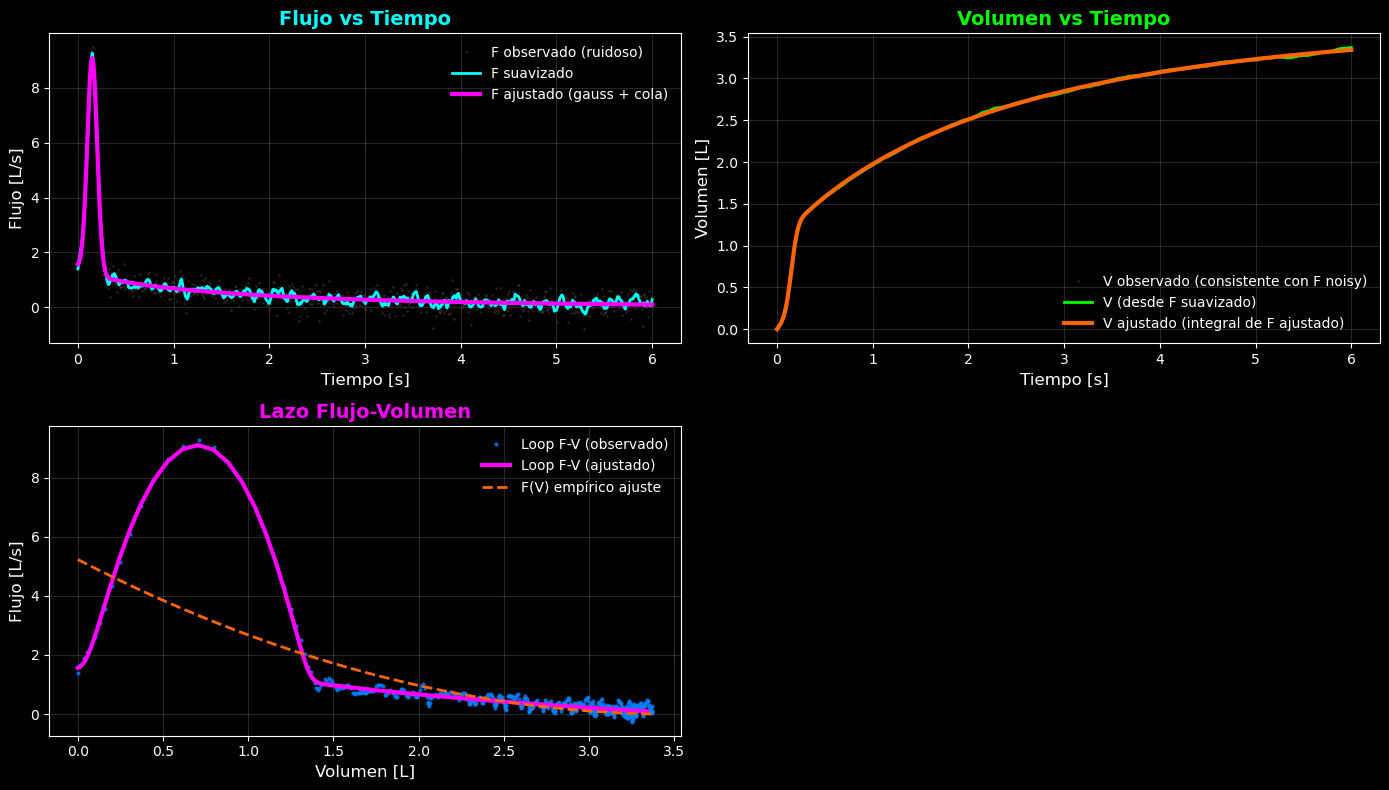

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.signal import savgol_filter

# ----------------------------
# Modelo: flujo = pico_gauss + cola_stretched_exp
# ----------------------------
def F_model(t, A, t0, sigma, B, tau, beta):
    """
    A: altura del pico (magnitud del flujo)
    t0: tiempo del pico
    sigma: anchura del pico
    B: amplitud de la cola (parte lenta)
    tau: tiempo característico de la cola
    beta: exponente de la cola (beta=1 => expo simple; beta<1 => cola larga)
    Devuelve flujo positiva (magnitud). Volumen(t) = integral_0^t F(t) dt
    """
    peak = A * np.exp(-0.5 * ((t - t0) / sigma) ** 2)
    tail = B * np.exp(- (t / tau) ** beta)
    return peak + tail

# ----------------------------
# Util: generar V desde F (integral)
# ----------------------------
def V_from_F(t, F):
    return cumulative_trapezoid(F, t, initial=0.0)

# ----------------------------
# Residuals para ajuste conjunto (V y F)
# ----------------------------
def residuals_params(p, t, V_obs=None, F_obs=None, weights=(1.0,1.0)):
    A, t0, sigma, B, tau, beta = p
    F_hat = F_model(t, A, t0, sigma, B, tau, beta)
    res = []
    if V_obs is not None:
        V_hat = V_from_F(t, F_hat)
        # normalizar para que magnitudes diferentes no desbalanceen la optimización
        normV = max(1e-3, np.max(np.abs(V_obs)))
        res.append(weights[0] * (V_hat - V_obs) / normV)
    if F_obs is not None:
        normF = max(1e-3, np.max(np.abs(F_obs)))
        res.append(weights[1] * (F_hat - F_obs) / normF)
    if len(res) == 0:
        return np.array([])
    return np.concatenate(res)

# ----------------------------
# Ejemplo sintético (sustituye por tus datos leyendo CSV)
# ----------------------------
# Si tienes un CSV con columnas "t,vol" o "t,flow", reemplaza esta sección por:
# data = np.loadtxt('mis_datos.csv', delimiter=',', skiprows=1)
# t = data[:,0]; V_obs = data[:,1]  (o F_obs = data[:,1])
t = np.linspace(0, 6, 600)  # tiempo [s], resolución fina
# Genero flujo sintético con pico agudo + cola larga (magnitud positiva, "expulsión" por unidad de tiempo)
F_true = F_model(t, A=8.0, t0=0.15, sigma=0.05, B=1.6, tau=1.2, beta=0.6)
V_true = V_from_F(t, F_true)

# Ruido y preprocesado (simula datos reales)
rng = np.random.default_rng(123)
F_obs = F_true + 0.3 * rng.normal(size=len(t))
V_obs = V_from_F(t, F_obs)  # asegura consistencia (si tu CSV trae volumen + ruido, mejor usarlo directamente)

# Filtrar suavemente (opcional)
F_obs_s = savgol_filter(F_obs, 11, 3)
V_obs_s = V_from_F(t, F_obs_s)

# ----------------------------
# Ajuste (least_squares)
# ----------------------------
# Parámetros iniciales y límites (ajusta según unidades)
p0 = [np.max(F_obs_s), 0.1, 0.05, np.max(F_obs_s)*0.2, 0.8, 0.8]
lower = [0.0, 0.0, 1e-4, 0.0, 1e-3, 0.1]
upper = [np.max(F_obs_s)*20, t[-1], t[-1], np.max(F_obs_s)*20, 10.0*t[-1], 3.0]

res = least_squares(residuals_params, p0, bounds=(lower,upper),
                    args=(t, V_obs_s, F_obs_s, (1.0,1.0)),
                    verbose=1)

p_opt = res.x
print("Parámetros óptimos (A, t0, sigma, B, tau, beta):", p_opt)

# ----------------------------
# Resultados: reconstruir
# ----------------------------
F_fit = F_model(t, *p_opt)
V_fit = V_from_F(t, F_fit)

# Errores
rms_V = np.sqrt(np.mean((V_fit - V_obs_s)**2))
rms_F = np.sqrt(np.mean((F_fit - F_obs_s)**2))
print(f"RMS volumen: {rms_V:.4f}, RMS flujo: {rms_F:.4f}")

# ----------------------------
# Ajuste alternativo: flujo vs volumen F(V) (modelo empírico)
# F(V) = a*(Vmax - V)^n  (útil para la porción descendente del loop flujo-volumen)
# ----------------------------
def F_of_V(V, a, Vmax, n):
    # evita valores negativos dentro de la potencia
    x = np.clip(Vmax - V, 0.0, None)
    return a * (x ** n)

# Sólo usar pares (V_obs_s, F_obs_s) y limitar a región donde F>0 y V>=0
mask = (F_obs_s > 0) & (V_obs_s >= 0)
try:
    pF, _ = curve_fit(F_of_V, V_obs_s[mask], F_obs_s[mask],
                      p0=[5.0, np.max(V_obs_s)*1.05, 1.0],
                      bounds=([0, 0.5*np.max(V_obs_s), 0.1], [100, 2*np.max(V_obs_s), 3.0]))
    print("Ajuste F(V) a*(Vmax - V)^n -> (a, Vmax, n):", pF)
    Fv_fit = F_of_V(V_obs_s, *pF)
except Exception as e:
    print("No fue posible ajustar F(V) con curve_fit:", e)
    pF = None
    Fv_fit = None

# ----------------------------
# Graficar resultados con estilo cyberpunk
# ----------------------------
plt.style.use('dark_background')
plt.figure(figsize=(14,8))

# Colores cyberpunk
neon_cyan = '#00FFFF'
neon_magenta = '#FF00FF'
neon_green = '#00FF00'
neon_orange = '#FF6600'
electric_blue = '#0080FF'

plt.subplot(2,2,1)
plt.plot(t, F_obs, '.', ms=2, alpha=0.4, color='#444444', label='F observado (ruidoso)')
plt.plot(t, F_obs_s, '-', color=neon_cyan, linewidth=2, label='F suavizado')
plt.plot(t, F_fit, '-', color=neon_magenta, lw=3, label='F ajustado (gauss + cola)')
plt.xlabel('Tiempo [s]', color='white', fontsize=12)
plt.ylabel('Flujo [L/s]', color='white', fontsize=12)
plt.legend(frameon=False, facecolor='black', edgecolor='white')
plt.title('Flujo vs Tiempo', color=neon_cyan, fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, color='gray')

plt.subplot(2,2,2)
plt.plot(t, V_obs, '.', ms=2, alpha=0.4, color='#444444', label='V observado (consistente con F noisy)')
plt.plot(t, V_obs_s, '-', color=neon_green, linewidth=2, label='V (desde F suavizado)')
plt.plot(t, V_fit, '-', color=neon_orange, lw=3, label='V ajustado (integral de F ajustado)')
plt.xlabel('Tiempo [s]', color='white', fontsize=12)
plt.ylabel('Volumen [L]', color='white', fontsize=12)
plt.legend(frameon=False, facecolor='black', edgecolor='white')
plt.title('Volumen vs Tiempo', color=neon_green, fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, color='gray')

plt.subplot(2,2,3)
plt.plot(V_obs_s, F_obs_s, '.', ms=4, alpha=0.7, color=electric_blue, label='Loop F-V (observado)')
plt.plot(V_fit, F_fit, '-', color=neon_magenta, lw=3, label='Loop F-V (ajustado)')
if Fv_fit is not None:
    plt.plot(V_obs_s, Fv_fit, '--', color=neon_orange, lw=2, label='F(V) empírico ajuste')
plt.xlabel('Volumen [L]', color='white', fontsize=12)
plt.ylabel('Flujo [L/s]', color='white', fontsize=12)
plt.legend(frameon=False, facecolor='black', edgecolor='white')
plt.title('Lazo Flujo-Volumen', color=neon_magenta, fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, color='gray')

plt.tight_layout()
plt.show()
